Stem tokens (using Porter stemmer) and insert tokens from docs into inverted index

In [1]:
import os

import nltk
from InvertedIndex import InvertedIndex  # Custom library
from ModelResults import ModelResults # Custom library
from nltk.stem import PorterStemmer
from VectorSpace import VectorSpace # Custom library

docs_path = "../Dataset/docs/"
docs_list = os.listdir(docs_path)

# Used later for query preprocessing
removed_frequent_words = []
replaced_words = {}

invertedIndex = InvertedIndex()
ps = PorterStemmer()

for doc_name in docs_list:
    file_path = os.path.join(docs_path, doc_name)
    doc = open(file_path)
    for token in doc:
        invertedIndex.insert(ps.stem(token[:-1].lower()), doc_name)
    doc.close()

Filter inverted tokens words using stopwords and replace tokens with synonyms

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("stopwords")
stopwords = stopwords.words("english")

for word in stopwords:
    invertedIndex.delete(ps.stem(word))

[nltk_data] Downloading package stopwords to /home/greg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Plot token frequency distribution in filtered inverted index

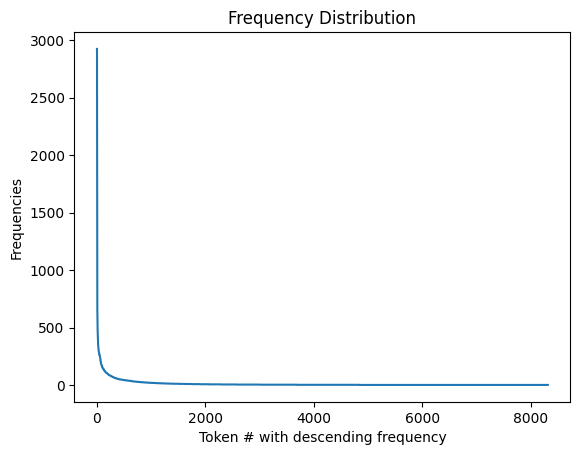

In [3]:
import operator

import matplotlib.pyplot as plt


def plotFrequencyDistribution():
    tokenFrequencies = {}
    for token, data in invertedIndex.getTokens():
        tokenFrequencies[token] = invertedIndex.countOccurances(token)
    tokenFrequencies = dict(
        sorted(tokenFrequencies.items(), key=operator.itemgetter(1), reverse=True)
    )
    plt.plot(
        range(len(list(tokenFrequencies.values()))), list(tokenFrequencies.values())
    )
    plt.title("Frequency Distribution")
    plt.xlabel("Token # with descending frequency")
    plt.ylabel("Frequencies")
    plt.show()
    return tokenFrequencies


tokenFrequencies = plotFrequencyDistribution()

As you can see, very few tokens are very frequent and the rest is very infrequent.

Thus I decided to remove very frequent tokens, that appear on mostly every document, since I don't want the information retrieval system to focus on those when computing answers to queries.

I also replaced infrequent tokens with synonyms, hoping that the synonyms would have a higher frequency in the docs, so that by doing the same replacements in the query tokens the answers of the infrequent tokens will be grouped with their synonyms.

I set the thresholds for the frequent token removal and the infrequent token replacement so that when later plotting the Frequency Distribution graph again, I will only have the "knee" of the currrent graph. This is an emperical rule to make sure that we don't have many very frequent or very infrequent tokens in the inverted index

In [4]:
from nltk.corpus import wordnet

nltk.download("wordnet")

# Remove frequent tokens
for token, frequency in tokenFrequencies.items():
    if frequency > 500:
        invertedIndex.delete(token)
        removed_frequent_words.append(token)
    else:
        break

# Replace infrequent words with synonyms
for token, frequency in reversed(tokenFrequencies.items()):
    if frequency < 5:
        synonyms = wordnet.synsets(token)
        for synonym in synonyms:
            new_token = ps.stem(synonym.lemmas()[0].name())  # type: ignore
            if (
                new_token != token
                and "_" not in new_token
                and new_token in invertedIndex.getTokens()
            ):
                replaced_words[token] = new_token
                invertedIndex.rename(token, new_token)
                break
    else:
        break

[nltk_data] Downloading package wordnet to /home/greg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Now i plot the frequency distribution again in order to evaluate what it looks like

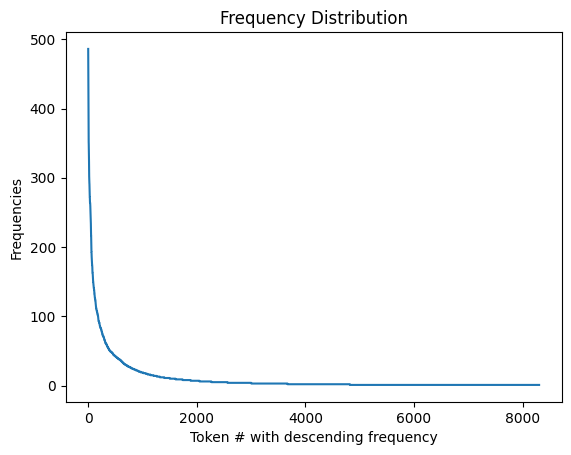

In [5]:
tokenFrequencies = plotFrequencyDistribution()

It is visible now that we are left with the "knee" of the original frequency distribution, so all very frequent and all very infrequent tokens are removed.
Now let's enter the documents and queries into the Vector Space Model:

In [6]:
with open("../Dataset/Queries_20") as queries:
    vectorSpace1 = VectorSpace(
        documents=docs_list,
        queries=queries,
        invertedIndex=invertedIndex,
        document_tf_weighting=VectorSpace.tf_simplefrequency,
        document_idf_weighting=VectorSpace.idf_logsimple,
        document_normalize_function=VectorSpace.cosine_normalization,
        query_tf_weighting=VectorSpace.tf_doublehalfnormalization,
        query_idf_weighting=VectorSpace.idf_logsimple,
        query_normalize_function=VectorSpace.no_normalization,
        query_stopwords=stopwords,
        query_removed_frequent_words=removed_frequent_words,
        query_replaced_words=replaced_words,
        query_stemmer=ps,
    )

with open("../Dataset/Queries_20") as queries:
    vectorSpace2 = VectorSpace(
        documents=docs_list,
        queries=queries,
        invertedIndex=invertedIndex,
        document_tf_weighting=VectorSpace.tf_simplefrequency,
        document_idf_weighting=VectorSpace.idf_one,
        document_normalize_function=VectorSpace.cosine_normalization,
        query_tf_weighting=VectorSpace.tf_doublehalfnormalization,
        query_idf_weighting=VectorSpace.idf_logsimple,
        query_normalize_function=VectorSpace.no_normalization,
        query_stopwords=stopwords,
        query_removed_frequent_words=removed_frequent_words,
        query_replaced_words=replaced_words,
        query_stemmer=ps,
    )

with open("../Dataset/Queries_20") as queries:
    vectorSpace3 = VectorSpace(
        documents=docs_list,
        queries=queries,
        invertedIndex=invertedIndex,
        document_tf_weighting=VectorSpace.tf_doublehalfnormalization,
        document_idf_weighting=VectorSpace.idf_lognormmax,
        document_normalize_function=VectorSpace.cosine_normalization,
        query_tf_weighting=VectorSpace.tf_doublehalfnormalization,
        query_idf_weighting=VectorSpace.idf_lognormmax,
        query_normalize_function=VectorSpace.cosine_normalization,
        query_stopwords=stopwords,
        query_removed_frequent_words=removed_frequent_words,
        query_replaced_words=replaced_words,
        query_stemmer=ps,
    )

In [7]:
vectorSpace1Results = [vectorSpace1.lookup(str(i), 80) for i in range(20)]
vectorSpace2Results = [vectorSpace2.lookup(str(i), 80) for i in range(20)]
vectorSpace3Results = [vectorSpace3.lookup(str(i), 80) for i in range(20)]

Calculate the correct answers from the dataset

In [8]:
correctAnswers = []


def processRelevant(relevant_string):
    relevant_string = relevant_string.split()
    relevant = {}
    flag = False
    for text in relevant_string:
        if not flag:
            doc_id = text
            flag = True
        else:
            score = 0
            for digit in text:
                score += int(digit)
            relevant[doc_id] = score  # type: ignore
            flag = False
    relevant = dict(sorted(relevant.items(), key=lambda item: item[1], reverse=True))
    return relevant


with open("../Dataset/cfquery_detailed", "r") as relevant:
    relevant_per_query = ""
    flag = False
    for line in relevant:
        if flag is False and line[0:2] == "RD":
            flag = True
            relevant_per_query += line[3:]
        elif flag is True and line[0:2] == "QN":
            flag = False
            correctAnswers.append(processRelevant(relevant_per_query))
            relevant_per_query = ""
        elif flag is True:
            relevant_per_query += line

Create ModelResults objects to compute metrics and gain ability to view and plot them

In [9]:
vectorSpace1Results = ModelResults(
    vectorSpace1Results, correctAnswers, "Vector Space 1"
)
vectorSpace2Results = ModelResults(
    vectorSpace2Results, correctAnswers, "Vector Space 2"
)
vectorSpace3Results = ModelResults(
    vectorSpace3Results, correctAnswers, "Vector Space 3"
)

Printing average precision, recall and DCG metrics

In [10]:
print(f"Vector Space 1 Mean Precision: {vectorSpace1Results.getMeanPrecision()}")
print(f"Vector Space 2 Mean Precision: {vectorSpace2Results.getMeanPrecision()}")
print(f"Vector Space 3 Mean Precision: {vectorSpace3Results.getMeanPrecision()}")

Vector Space 1 Mean Precision: [0.05263157894736842, 0.10526315789473684, 0.10526315789473684, 0.07894736842105263, 0.08421052631578947, 0.07017543859649122, 0.06015037593984962, 0.05263157894736842, 0.04678362573099415, 0.042105263157894736, 0.0430622009569378, 0.039473684210526314, 0.03643724696356275, 0.03383458646616541, 0.031578947368421054, 0.029605263157894735, 0.030959752321981424, 0.032163742690058485, 0.03324099722991689, 0.042105263157894736, 0.045112781954887216, 0.0430622009569378, 0.041189931350114416, 0.03947368421052632, 0.042105263157894736, 0.040485829959514164, 0.03898635477582846, 0.03759398496240601, 0.036297640653357534, 0.03508771929824561, 0.03735144312393888, 0.04111842105263158, 0.04784688995215312, 0.04643962848297214, 0.04511278195488722, 0.04385964912280702, 0.0469416785206259, 0.04847645429362881, 0.04723346828609986, 0.046052631578947366, 0.04621309370988447, 0.051378446115288225, 0.050183598531211744, 0.049043062200956944, 0.04795321637426899, 0.04691075

In [11]:
print(f"Vector Space 1 Mean Recall: {vectorSpace1Results.getMeanRecall()}")
print(f"Vector Space 2 Mean Recall: {vectorSpace2Results.getMeanRecall()}")
print(f"Vector Space 3 Mean Recall: {vectorSpace3Results.getMeanRecall()}")

Vector Space 1 Mean Recall: [0.0004017677782241864, 0.0020528710163101485, 0.0027470364553530482, 0.0027470364553530482, 0.003545506990665689, 0.003545506990665689, 0.003545506990665689, 0.003545506990665689, 0.003545506990665689, 0.003545506990665689, 0.003947274768889875, 0.003947274768889875, 0.003947274768889875, 0.003947274768889875, 0.003947274768889875, 0.003947274768889875, 0.004349042547114062, 0.0067413870447217165, 0.00703378470554043, 0.010982175496036485, 0.013576925730401023, 0.013576925730401023, 0.013576925730401023, 0.013576925730401023, 0.015526681124724282, 0.015526681124724282, 0.015526681124724282, 0.015526681124724282, 0.015526681124724282, 0.015526681124724282, 0.017152439111026804, 0.020594757027028926, 0.028083817673984313, 0.028083817673984313, 0.028083817673984313, 0.028083817673984313, 0.029284055987521134, 0.03187880622188568, 0.03187880622188568, 0.03187880622188568, 0.03217120388270439, 0.035285317794327344, 0.035285317794327344, 0.035285317794327344, 0.0

In [12]:
print(f"Vector Space 1 Mean DCG: {vectorSpace1Results.getMeanDCG()}")
print(f"Vector Space 2 Mean DCG: {vectorSpace2Results.getMeanDCG()}")
print(f"Vector Space 3 Mean DCG: {vectorSpace3Results.getMeanDCG()}")

Vector Space 1 Mean DCG: [0.05263157894736842, 0.2631578947368421, 0.3295715530075219, 0.3295715530075219, 0.42024030207560464, 0.42024030207560464, 0.42024030207560464, 0.42024030207560464, 0.42024030207560464, 0.42024030207560464, 0.4354542403028619, 0.4354542403028619, 0.4354542403028619, 0.4354542403028619, 0.4354542403028619, 0.4354542403028619, 0.44833058462487374, 0.4609522933916175, 0.47334223620038796, 0.5464090403561014, 0.5823569743608835, 0.5823569743608835, 0.5823569743608835, 0.5823569743608835, 0.6050241616279041, 0.6050241616279041, 0.6050241616279041, 0.6050241616279041, 0.6050241616279041, 0.6050241616279041, 0.6475187061715041, 0.7948871272241357, 1.003560667403673, 1.003560667403673, 1.003560667403673, 1.003560667403673, 1.0540761200369784, 1.0941922068636678, 1.0941922068636678, 1.0941922068636678, 1.1138398290993459, 1.1626422036823376, 1.1626422036823376, 1.1626422036823376, 1.1626422036823376, 1.1626422036823376, 1.2573955335016496, 1.2573955335016496, 1.2855171

Displaying comparison precision recall curve

Displaying comparison DCG curve

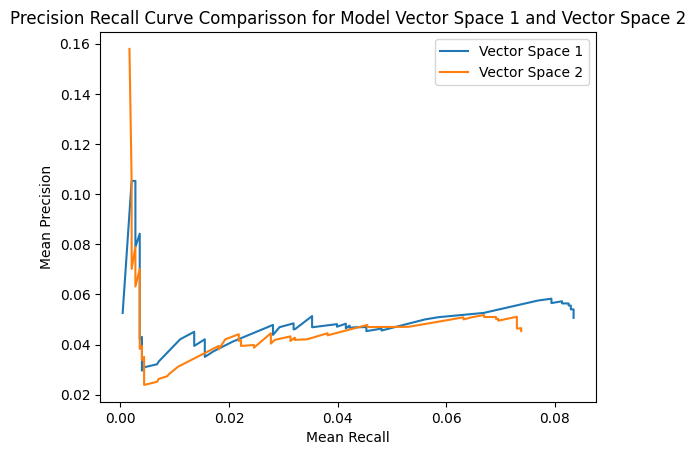

In [13]:
vectorSpace1Results.compare_mean_precision_recall_curve(vectorSpace2Results)

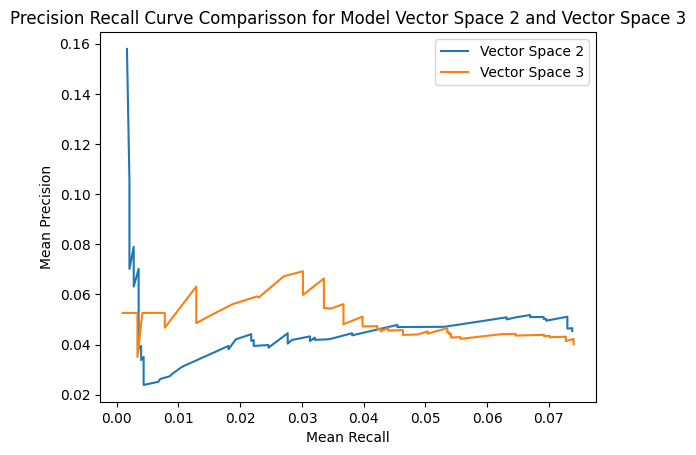

In [14]:
vectorSpace2Results.compare_mean_precision_recall_curve(vectorSpace3Results)

Displaying comparison DCG curve

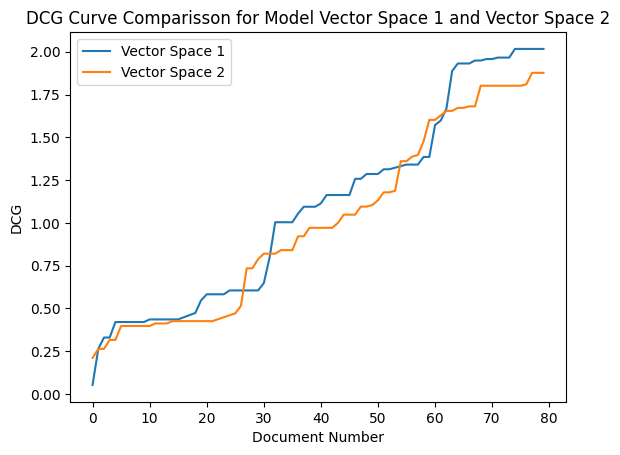

In [15]:
vectorSpace1Results.compare_mean_dcg_curve(vectorSpace2Results)

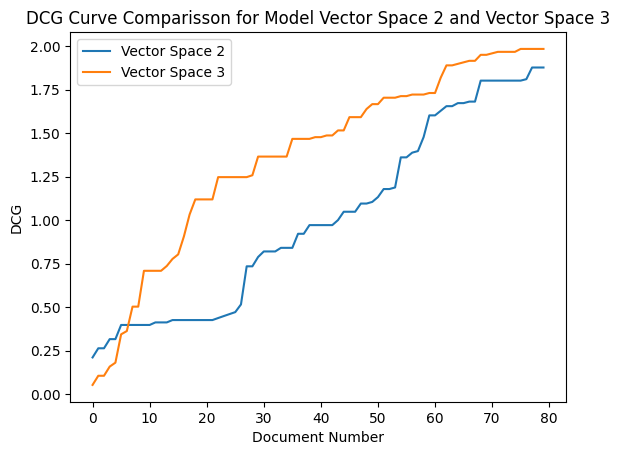

In [16]:
vectorSpace2Results.compare_mean_dcg_curve(vectorSpace3Results)